In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
import jReversion as jR
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
import networkx as nx
from statannot import add_stat_annotation
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
kmf = KaplanMeierFitter()

In [2]:
oncoprint_pd = pd.read_csv('../data/BRCA/blt_BRCA_PATIENT_DATA_oncoprint_TCGA_PanCancer.tsv', sep='\t')
# gene_node_pd = pd.read_csv('../data/BLCA_200919/Grieco_gene_node_mapping.csv')
gene_node_pd = pd.read_csv('../data/BRCA/blt_gene_node.csv')
# print(gene_node_pd.head())

os_pd = pd.read_csv('../data/BRCA/Overall_blt_BRCA_TCGA_PanCancer.csv')
dfs_pd = pd.read_csv('../data/BRCA/Disease_Free_blt_BRCA_TCGA_PanCancer.csv')

table_original_network = pd.read_csv('../data/BLT_table_for_original_network.tsv', sep='\t').sort_values(by='node')

pfs_pd = pd.read_csv('../data/BRCA/Progression_Free_erbb_BRCA_TCGA_PanCancer.csv')


In [3]:
oncoprint_mut_pd = oncoprint_pd[oncoprint_pd['track_type']=='MUTATIONS']
oncoprint_cna_pd = oncoprint_pd[oncoprint_pd['track_type']=='CNA']
oncoprint_mrna_pd = oncoprint_pd[oncoprint_pd['track_type']=='MRNA']

In [4]:
oncoprint_mrna_melt_pd = pd.melt(oncoprint_mrna_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
oncoprint_mrna_pivot_pd = pd.pivot(oncoprint_mrna_melt_pd[['track_name', 'Case ID', 'event']], index='Case ID', columns='track_name', values='event').sort_index()
oncoprint_cna_melt_pd = pd.melt(oncoprint_cna_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
oncoprint_cna_pivot_pd = pd.pivot(oncoprint_cna_melt_pd[['track_name', 'Case ID', 'event']], index='Case ID', columns='track_name', values='event').sort_index()
oncoprint_mut_melt_pd = pd.melt(oncoprint_mut_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
oncoprint_mut_pivot_pd = pd.pivot(oncoprint_mut_melt_pd[['track_name', 'Case ID', 'event']], index='Case ID', columns='track_name', values='event').sort_index()


In [5]:
cna_mrna_consistent_pivot_pd = ((oncoprint_cna_pivot_pd == 'Amplification') & (oncoprint_mrna_pivot_pd  == 'mRNA High')) | ((oncoprint_cna_pivot_pd  == 'Deep Deletion') & (oncoprint_mrna_pivot_pd == 'mRNA Low'))
print(cna_mrna_consistent_pivot_pd.head())
mrna_not_low_pivot_pd = ~(oncoprint_mrna_pivot_pd == 'mRNA Low')
print(mrna_not_low_pivot_pd.head())

track_name     AKT1  BCL11A  CCDC170  CCND1   EGFR   ESR1  FOXA1  FOXC1  \
Case ID                                                                   
TCGA-3C-AAAU  False   False    False   True  False  False  False  False   
TCGA-3C-AALI  False   False    False  False  False  False  False  False   
TCGA-3C-AALJ  False   False    False  False  False  False  False  False   
TCGA-3C-AALK  False   False    False  False  False  False  False  False   
TCGA-4H-AAAK  False   False    False  False  False  False  False  False   

track_name    GATA3  HDAC1  ...   KRAS  MAPK1  MAPK3  PIK3CA   PTEN  SNAI1  \
Case ID                     ...                                              
TCGA-3C-AAAU  False  False  ...  False  False  False   False  False  False   
TCGA-3C-AALI  False  False  ...  False  False  False   False  False  False   
TCGA-3C-AALJ  False  False  ...  False  False  False   False  False   True   
TCGA-3C-AALK  False  False  ...  False  False  False   False  False  False   
TCGA-4

In [6]:
alteration_cna_melt_pd = pd.melt(oncoprint_cna_pivot_pd[cna_mrna_consistent_pivot_pd].reset_index(), id_vars='Case ID', var_name='track_name', value_name='event')
alteration_mut_melt_pd = pd.melt(oncoprint_mut_pivot_pd[mrna_not_low_pivot_pd].reset_index(), id_vars='Case ID', var_name='track_name', value_name='event')                                 

In [7]:
alteration_cna_melt_pd['track_type'] = 'CNA'
alteration_mut_melt_pd['track_type'] = 'MUTATIONS'

In [8]:
# oncoprint_melt_pd = pd.melt(oncoprint_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
# oncoprint_pivot = pd.pivot_table(oncoprint_melt_pd.fillna(''), index=['Case ID', 'track_name'], columns='track_type', values='event', aggfunc=lambda x: ' '.join(x))

In [9]:
alteration_cna_mut_melt_pd = pd.concat([alteration_cna_melt_pd, alteration_mut_melt_pd])
# oncoprint_cna_mrna_mut_melt_pd = pd.melt(oncoprint_cna_mrna_mut_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')

In [10]:
event_count_pd = pd.merge(alteration_cna_mut_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol').set_index(['track_name', 'track_type', 'node_name']).count(level='node_name')
print(event_count_pd.head())

           Case ID  event  gene_symbol
node_name                             
AKT           1988     37         1988
BCL11A        1988      9         1988
C6orf97       1988     11         1988
CCND1         1988     96         1988
EGFR          1988     26         1988


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C0 v.s. C1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.340e-01 U_stat=1.700e+01
C1 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.716e-01 U_stat=9.000e+00
C0 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+01


(<matplotlib.axes._subplots.AxesSubplot at 0x7f26f7524588>,
  <statannot.StatResult.StatResult at 0x7f26f54c95c0>])

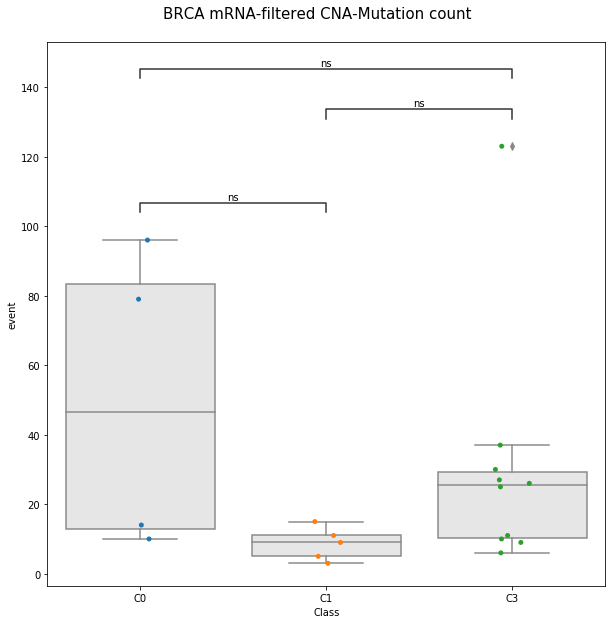

In [11]:
result = pd.merge(event_count_pd, table_original_network, left_on='node_name', right_on='node')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('BRCA mRNA-filtered CNA-Mutation count', fontsize=15, y=0.93)
ax = sns.stripplot(data=result.sort_values('Class'), x='Class', y='event')
ax = sns.boxplot(data=result.sort_values('Class'), x='Class', y='event', color='.9', ax=ax)

add_stat_annotation(ax=ax, data=result.sort_values('Class'), x='Class', y='event',
                    box_pairs=[("C0", "C1"), ("C1", "C3"), ("C0", "C3")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig('../data/BLCA_200919/alter_freq_BLCA.pdf', dpi=300)

In [12]:
oncoprint_node_pd = pd.merge(alteration_cna_mut_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')

In [13]:
# oncoprint_node_class_pd['mutation_sign'] = 1*(oncoprint_node_class_pd['oncoKB'] == 'Oncogene') - 1*(oncoprint_node_class_pd['oncoKB'] == 'Tumor Suppressor')
# oncoprint_node_class_pd.head()

In [14]:
set(oncoprint_node_class_pd['event'])

{'Amplification',
 'Deep Deletion',
 'Inframe Mutation (putative driver)',
 'Inframe Mutation (putative passenger)',
 'Missense Mutation (putative driver)',
 'Missense Mutation (putative passenger)',
 'Truncating mutation (putative driver)',
 'Truncating mutation (putative passenger)'}

In [15]:
oncoprint_node_class_pd['alteration'] = 1
# oncoprint_node_class_pd['alteration'] = 100 * (oncoprint_node_class_pd['event'] == 'Amplification') - 100 * (oncoprint_node_class_pd['event'] == 'Deep Deletion') -10 * (oncoprint_node_class_pd['event'].str.contains('Truncating mutation')) + 1 * (oncoprint_node_class_pd['event'].str.contains('Mutation')) * oncoprint_node_class_pd['mutation_sign']
print(oncoprint_node_class_pd.head())

        Case ID track_name          event track_type gene_symbol node_name  \
0  TCGA-A8-A06R       AKT1  Amplification        CNA        AKT1       AKT   
1  TCGA-AC-A3W5       AKT1  Amplification        CNA        AKT1       AKT   
2  TCGA-AN-A0AS       AKT1  Amplification        CNA        AKT1       AKT   
3  TCGA-AO-A0JD       AKT1  Amplification        CNA        AKT1       AKT   
4  TCGA-BH-A0HY       AKT1  Amplification        CNA        AKT1       AKT   

  node Class  alteration  
0  AKT    C3           1  
1  AKT    C3           1  
2  AKT    C3           1  
3  AKT    C3           1  
4  AKT    C3           1  


Class          C0   C1   C3  score
Case ID                           
TCGA-3C-AAAU  1.0  0.0  1.0    1.0
TCGA-3C-AALJ  0.0  1.0  1.0    0.0
TCGA-5T-A9QA  1.0  0.0  0.0    0.0
TCGA-A1-A0SD  1.0  0.0  1.0    1.0
TCGA-A1-A0SJ  0.0  1.0  0.0   -1.0


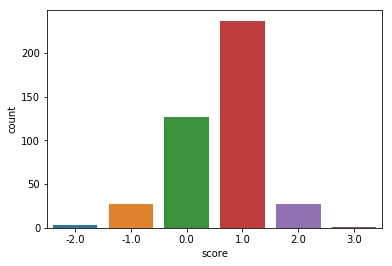

In [16]:
oncoprint_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_reverse_controllability = oncoprint_reverse_controllability.fillna(0)

# oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C2'] + oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
print(oncoprint_reverse_controllability.head())

sns.countplot(data=oncoprint_reverse_controllability, x='score')

In [17]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
pfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, pfs_pd, left_index=True, right_on='Case ID')

Text(0, 0.5, 'Survival')

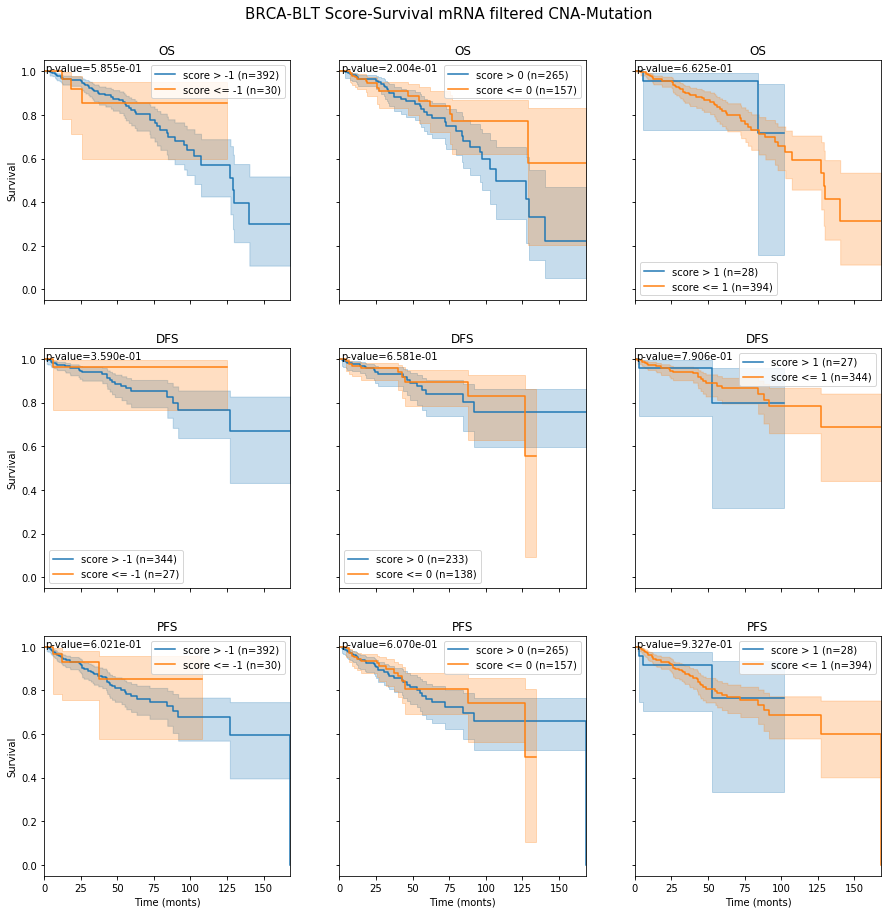

In [18]:
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True, sharex=True)
f.suptitle('BRCA-BLT Score-Survival mRNA filtered CNA-Mutation', fontsize=15, y=0.93)

ax = axes[0,1]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,1]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,1]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,2]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,2]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,2]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,0]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

Text(0, 0.5, 'Overall survival')

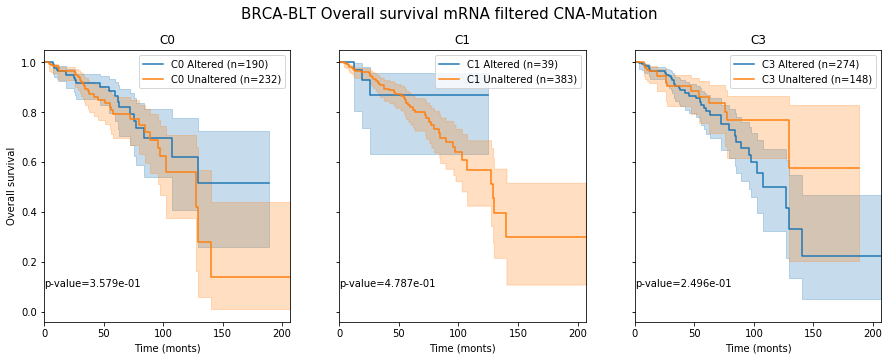

In [19]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Overall survival mRNA filtered CNA-Mutation', fontsize=15, y=1)

ax = axes[0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

# ax = axes[1,0]
# # data = c2_data
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['C2'] > 0.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
# ax.set_title('C2')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Overall survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

Text(0, 0.5, 'Disease free survival')

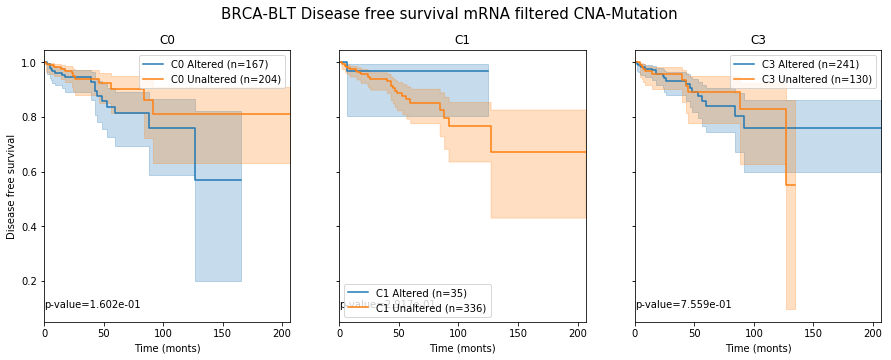

In [20]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Disease free survival mRNA filtered CNA-Mutation', fontsize=15, y=1)

ax = axes[0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

Text(0, 0.5, 'Progression free survival')

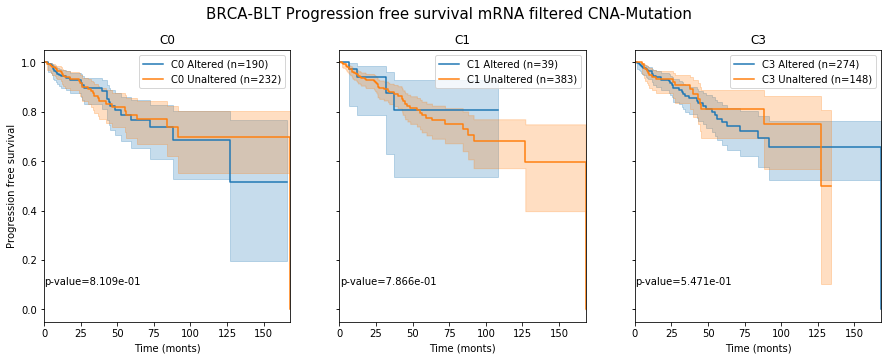

In [21]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Progression free survival mRNA filtered CNA-Mutation', fontsize=15, y=1)

ax = axes[0]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

In [22]:
alteration_driver_melt_pd = alteration_mut_melt_pd[alteration_mut_melt_pd['event'].str.contains('passenger')==False]
alteration_cna_driver_melt_pd = pd.concat([alteration_cna_melt_pd, alteration_driver_melt_pd])

In [23]:
event_count_pd = pd.merge(alteration_cna_driver_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol').set_index(['track_name', 'track_type', 'node_name']).count(level='node_name')
print(event_count_pd.head())

           Case ID  event  gene_symbol
node_name                             
AKT           1020     36         1020
BCL11A         994      5          994
C6orf97        994      4          994
CCND1          994     95          994
EGFR           997     14          997


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C0 v.s. C1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.110e-01 U_stat=1.500e+01
C1 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.923e-01 U_stat=1.600e+01
C0 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.400e+01


(<matplotlib.axes._subplots.AxesSubplot at 0x7f26f4da66a0>,
  <statannot.StatResult.StatResult at 0x7f26f4f6af98>])

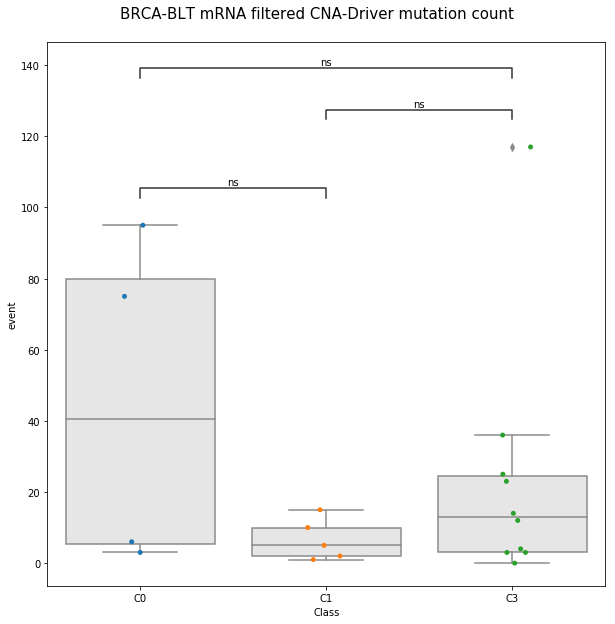

In [24]:
result = pd.merge(event_count_pd, table_original_network, left_on='node_name', right_on='node')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('BRCA-BLT mRNA filtered CNA-Driver mutation count', fontsize=15, y=0.93)
ax = sns.stripplot(data=result.sort_values('Class'), x='Class', y='event')
ax = sns.boxplot(data=result.sort_values('Class'), x='Class', y='event', color='.9', ax=ax)

add_stat_annotation(ax=ax, data=result.sort_values('Class'), x='Class', y='event',
                    box_pairs=[("C0", "C1"), ("C1", "C3"), ("C0", "C3")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig('../data/BLCA_200919/alter_freq_BLCA.pdf', dpi=300)

In [25]:
oncoprint_node_pd = pd.merge(alteration_cna_driver_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')

In [26]:
# oncoprint_node_class_pd['mutation_sign'] = 1*(oncoprint_node_class_pd['oncoKB'] == 'Oncogene') - 1*(oncoprint_node_class_pd['oncoKB'] == 'Tumor Suppressor')
# oncoprint_node_class_pd.head()

In [27]:
set(oncoprint_node_class_pd['event'])

{'Amplification',
 'Deep Deletion',
 'Inframe Mutation (putative driver)',
 'Missense Mutation (putative driver)',
 'Truncating mutation (putative driver)'}

In [28]:
oncoprint_node_class_pd['alteration'] = 1
# oncoprint_node_class_pd['alteration'] = 100 * (oncoprint_node_class_pd['event'] == 'Amplification') - 100 * (oncoprint_node_class_pd['event'] == 'Deep Deletion') -10 * (oncoprint_node_class_pd['event'].str.contains('Truncating mutation')) + 1 * (oncoprint_node_class_pd['event'].str.contains('Mutation')) * oncoprint_node_class_pd['mutation_sign']
print(oncoprint_node_class_pd.head())

        Case ID track_name          event track_type gene_symbol node_name  \
0  TCGA-A8-A06R       AKT1  Amplification        CNA        AKT1       AKT   
1  TCGA-AC-A3W5       AKT1  Amplification        CNA        AKT1       AKT   
2  TCGA-AN-A0AS       AKT1  Amplification        CNA        AKT1       AKT   
3  TCGA-AO-A0JD       AKT1  Amplification        CNA        AKT1       AKT   
4  TCGA-BH-A0HY       AKT1  Amplification        CNA        AKT1       AKT   

  node Class  alteration  
0  AKT    C3           1  
1  AKT    C3           1  
2  AKT    C3           1  
3  AKT    C3           1  
4  AKT    C3           1  


Class          C0   C1   C3  score
Case ID                           
TCGA-3C-AAAU  1.0  0.0  1.0    1.0
TCGA-3C-AALJ  0.0  1.0  1.0    0.0
TCGA-5T-A9QA  1.0  0.0  0.0    0.0
TCGA-A1-A0SD  1.0  0.0  1.0    1.0
TCGA-A1-A0SM  1.0  0.0  0.0    0.0


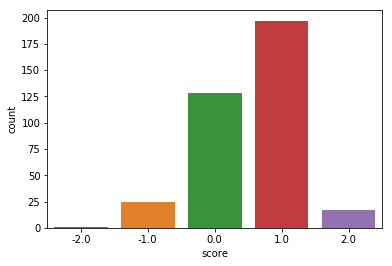

In [29]:
oncoprint_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_reverse_controllability = oncoprint_reverse_controllability.fillna(0)

oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
# oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C2'] + oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
print(oncoprint_reverse_controllability.head())

sns.countplot(data=oncoprint_reverse_controllability, x='score')

In [30]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
pfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, pfs_pd, left_index=True, right_on='Case ID')

Text(0, 0.5, 'Survival')

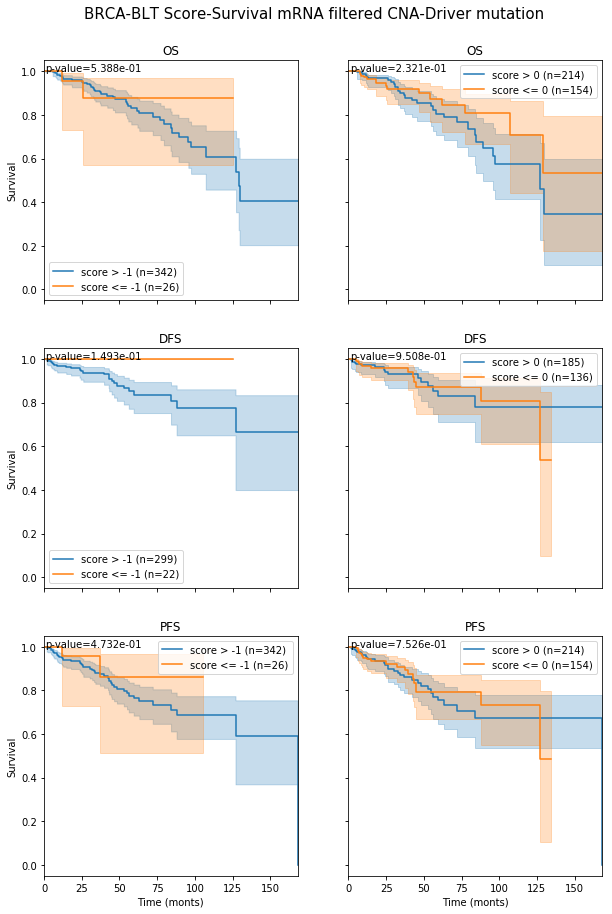

In [31]:
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(3, 2, figsize=(10, 15), sharey=True, sharex=True)
f.suptitle('BRCA-BLT Score-Survival mRNA filtered CNA-Driver mutation', fontsize=15, y=0.93)

ax = axes[0,1]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,1]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,1]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

# ax = axes[0,2]
# data = os_oncoprint_pd
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['score'] > 1.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(1, 1, 'p-value=%.3e'% results.p_value)
# ax.set_title('OS')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Survival')

# ax = axes[1,2]
# data = dfs_oncoprint_pd
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['score'] > 1.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(1, 1, 'p-value=%.3e'% results.p_value)
# ax.set_title('DFS')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Survival')

# ax = axes[2,2]
# data = pfs_oncoprint_pd
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['score'] > 1.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(1, 1, 'p-value=%.3e'% results.p_value)
# ax.set_title('PFS')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Survival')

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,0]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

Text(0, 0.5, 'Overall survival')

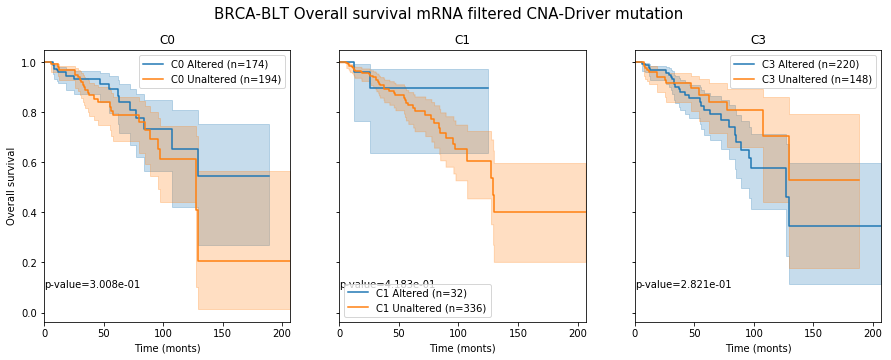

In [32]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Overall survival mRNA filtered CNA-Driver mutation', fontsize=15, y=1)

ax = axes[0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

# ax = axes[1,0]
# # data = c2_data
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['C2'] > 0.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
# ax.set_title('C2')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Overall survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

Text(0, 0.5, 'Disease free survival')

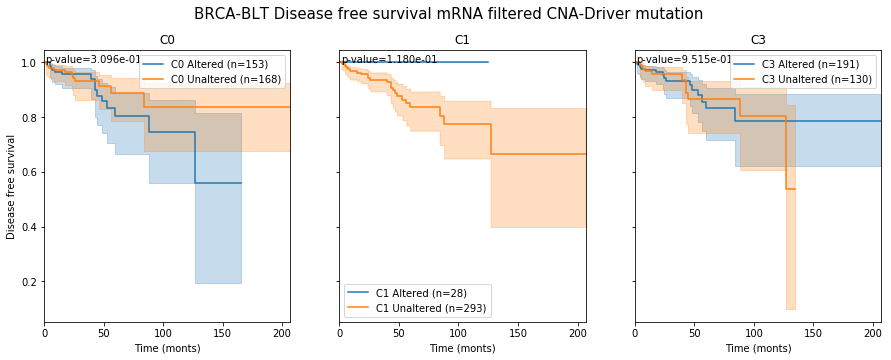

In [33]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Disease free survival mRNA filtered CNA-Driver mutation', fontsize=15, y=1)

ax = axes[0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

Text(0, 0.5, 'Progression free survival')

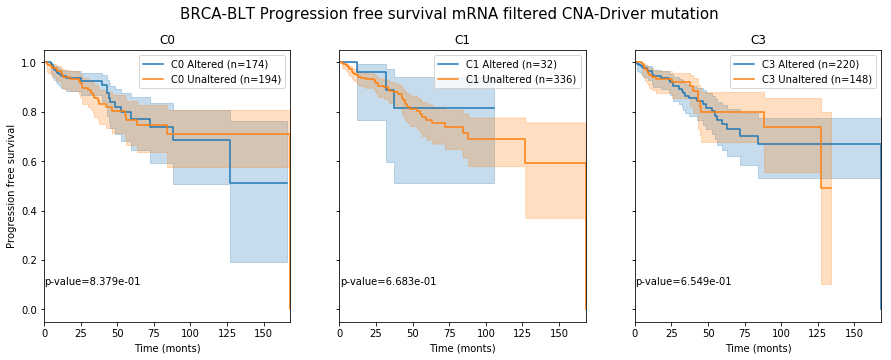

In [34]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Progression free survival mRNA filtered CNA-Driver mutation', fontsize=15, y=1)

ax = axes[0]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

In [35]:
# mRNA-mut filter remove

In [36]:
cna_mrna_consistent_pivot_pd = ((oncoprint_cna_pivot_pd == 'Amplification') & (oncoprint_mrna_pivot_pd  == 'mRNA High')) | ((oncoprint_cna_pivot_pd  == 'Deep Deletion') & (oncoprint_mrna_pivot_pd == 'mRNA Low'))
print(cna_mrna_consistent_pivot_pd.head())
mrna_not_low_pivot_pd = ~(oncoprint_mrna_pivot_pd == 'mRNA Low')
print(mrna_not_low_pivot_pd.head())

track_name     AKT1  BCL11A  CCDC170  CCND1   EGFR   ESR1  FOXA1  FOXC1  \
Case ID                                                                   
TCGA-3C-AAAU  False   False    False   True  False  False  False  False   
TCGA-3C-AALI  False   False    False  False  False  False  False  False   
TCGA-3C-AALJ  False   False    False  False  False  False  False  False   
TCGA-3C-AALK  False   False    False  False  False  False  False  False   
TCGA-4H-AAAK  False   False    False  False  False  False  False  False   

track_name    GATA3  HDAC1  ...   KRAS  MAPK1  MAPK3  PIK3CA   PTEN  SNAI1  \
Case ID                     ...                                              
TCGA-3C-AAAU  False  False  ...  False  False  False   False  False  False   
TCGA-3C-AALI  False  False  ...  False  False  False   False  False  False   
TCGA-3C-AALJ  False  False  ...  False  False  False   False  False   True   
TCGA-3C-AALK  False  False  ...  False  False  False   False  False  False   
TCGA-4

In [37]:
alteration_cna_melt_pd = pd.melt(oncoprint_cna_pivot_pd[cna_mrna_consistent_pivot_pd].reset_index(), id_vars='Case ID', var_name='track_name', value_name='event')
alteration_mut_melt_pd = pd.melt(oncoprint_mut_pivot_pd.reset_index(), id_vars='Case ID', var_name='track_name', value_name='event')                                 

In [38]:
alteration_cna_melt_pd['track_type'] = 'CNA'
alteration_mut_melt_pd['track_type'] = 'MUTATIONS'

In [39]:
# oncoprint_melt_pd = pd.melt(oncoprint_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')
# oncoprint_pivot = pd.pivot_table(oncoprint_melt_pd.fillna(''), index=['Case ID', 'track_name'], columns='track_type', values='event', aggfunc=lambda x: ' '.join(x))

In [40]:
alteration_cna_mut_melt_pd = pd.concat([alteration_cna_melt_pd, alteration_mut_melt_pd])
# oncoprint_cna_mrna_mut_melt_pd = pd.melt(oncoprint_cna_mrna_mut_pd, id_vars=['track_name', 'track_type'], var_name='Case ID', value_name='event')

In [41]:
event_count_pd = pd.merge(alteration_cna_mut_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol').set_index(['track_name', 'track_type', 'node_name']).count(level='node_name')
print(event_count_pd.head())

           Case ID  event  gene_symbol
node_name                             
AKT           1988     37         1988
BCL11A        1988      9         1988
C6orf97       1988     11         1988
CCND1         1988     96         1988
EGFR          1988     26         1988


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C0 v.s. C1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.340e-01 U_stat=1.700e+01
C1 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.716e-01 U_stat=9.000e+00
C0 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.450e+01


(<matplotlib.axes._subplots.AxesSubplot at 0x7f26eebd6cf8>,
  <statannot.StatResult.StatResult at 0x7f26eed8c438>])

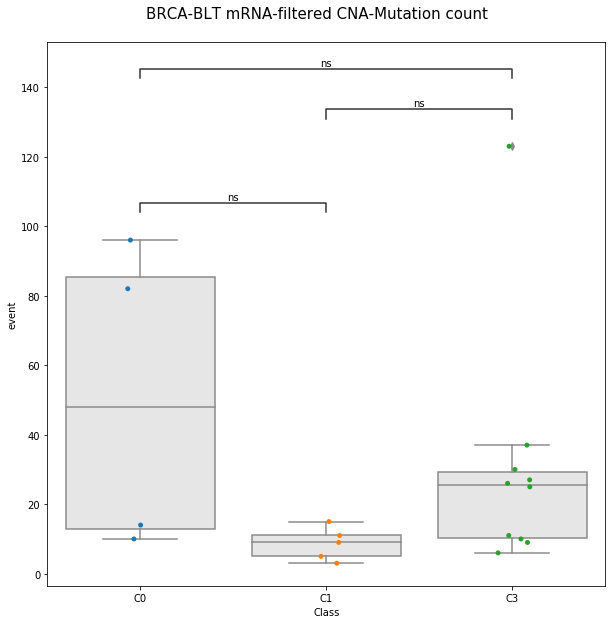

In [42]:
result = pd.merge(event_count_pd, table_original_network, left_on='node_name', right_on='node')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('BRCA-BLT mRNA-filtered CNA-Mutation count', fontsize=15, y=0.93)
ax = sns.stripplot(data=result.sort_values('Class'), x='Class', y='event')
ax = sns.boxplot(data=result.sort_values('Class'), x='Class', y='event', color='.9', ax=ax)

add_stat_annotation(ax=ax, data=result.sort_values('Class'), x='Class', y='event',
                    box_pairs=[("C0", "C1"), ("C1", "C3"), ("C0", "C3")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig('../data/BLCA_200919/alter_freq_BLCA.pdf', dpi=300)

In [43]:
oncoprint_node_pd = pd.merge(alteration_cna_mut_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')

In [44]:
# oncoprint_node_class_pd['mutation_sign'] = 1*(oncoprint_node_class_pd['oncoKB'] == 'Oncogene') - 1*(oncoprint_node_class_pd['oncoKB'] == 'Tumor Suppressor')
# oncoprint_node_class_pd.head()

In [45]:
set(oncoprint_node_class_pd['event'])

{'Amplification',
 'Deep Deletion',
 'Inframe Mutation (putative driver)',
 'Inframe Mutation (putative passenger)',
 'Missense Mutation (putative driver)',
 'Missense Mutation (putative passenger)',
 'Truncating mutation (putative driver)',
 'Truncating mutation (putative passenger)'}

In [46]:
oncoprint_node_class_pd['alteration'] = 1
# oncoprint_node_class_pd['alteration'] = 100 * (oncoprint_node_class_pd['event'] == 'Amplification') - 100 * (oncoprint_node_class_pd['event'] == 'Deep Deletion') -10 * (oncoprint_node_class_pd['event'].str.contains('Truncating mutation')) + 1 * (oncoprint_node_class_pd['event'].str.contains('Mutation')) * oncoprint_node_class_pd['mutation_sign']
print(oncoprint_node_class_pd.head())

        Case ID track_name          event track_type gene_symbol node_name  \
0  TCGA-A8-A06R       AKT1  Amplification        CNA        AKT1       AKT   
1  TCGA-AC-A3W5       AKT1  Amplification        CNA        AKT1       AKT   
2  TCGA-AN-A0AS       AKT1  Amplification        CNA        AKT1       AKT   
3  TCGA-AO-A0JD       AKT1  Amplification        CNA        AKT1       AKT   
4  TCGA-BH-A0HY       AKT1  Amplification        CNA        AKT1       AKT   

  node Class  alteration  
0  AKT    C3           1  
1  AKT    C3           1  
2  AKT    C3           1  
3  AKT    C3           1  
4  AKT    C3           1  


Class          C0   C1   C3  score
Case ID                           
TCGA-3C-AAAU  1.0  0.0  1.0    1.0
TCGA-3C-AALJ  0.0  1.0  1.0    0.0
TCGA-5T-A9QA  1.0  0.0  0.0    0.0
TCGA-A1-A0SD  1.0  0.0  1.0    1.0
TCGA-A1-A0SJ  0.0  1.0  0.0   -1.0


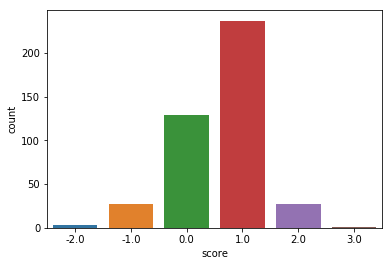

In [47]:
oncoprint_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_reverse_controllability = oncoprint_reverse_controllability.fillna(0)

oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
# oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C2'] + oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
print(oncoprint_reverse_controllability.head())

sns.countplot(data=oncoprint_reverse_controllability, x='score')

In [48]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
pfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, pfs_pd, left_index=True, right_on='Case ID')

Text(0, 0.5, 'Survival')

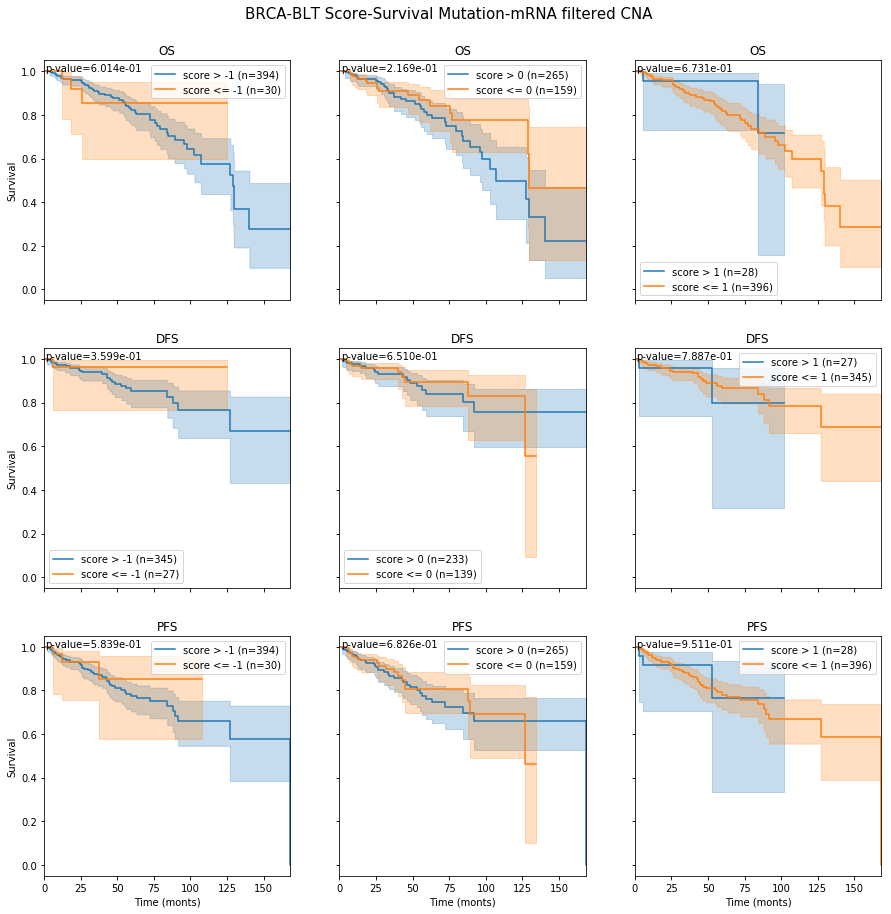

In [49]:
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=True, sharex=True)
f.suptitle('BRCA-BLT Score-Survival Mutation-mRNA filtered CNA', fontsize=15, y=0.93)

ax = axes[0,1]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,1]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,1]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,2]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,2]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,2]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,0]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

Text(0, 0.5, 'Overall survival')

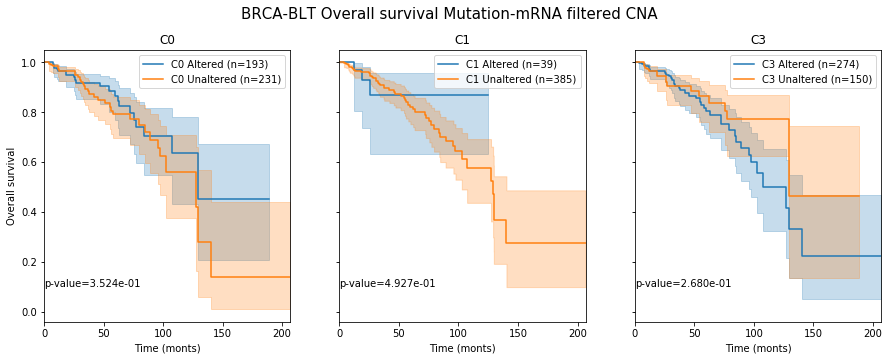

In [50]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Overall survival Mutation-mRNA filtered CNA', fontsize=15, y=1)

ax = axes[0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

# ax = axes[1,0]
# # data = c2_data
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['C2'] > 0.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
# ax.set_title('C2')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Overall survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

Text(0, 0.5, 'Disease free survival')

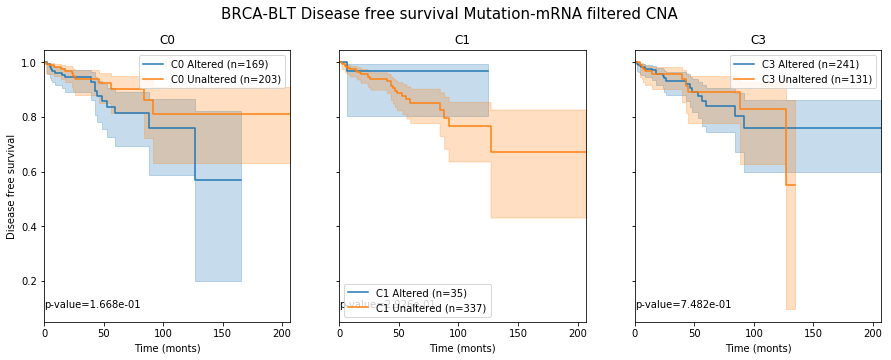

In [51]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Disease free survival Mutation-mRNA filtered CNA', fontsize=15, y=1)

ax = axes[0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

Text(0, 0.5, 'Progression free survival')

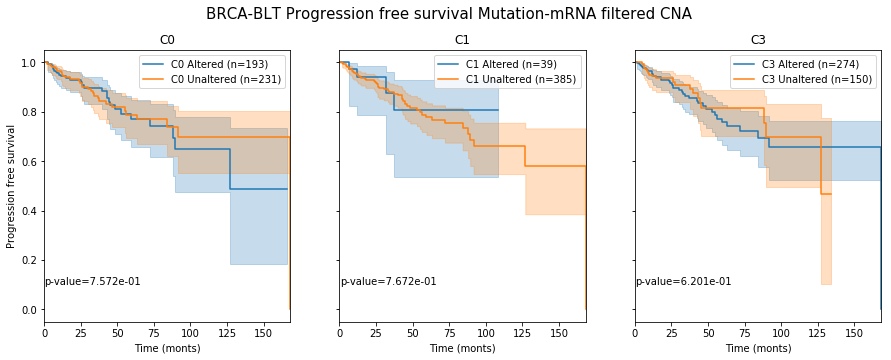

In [52]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Progression free survival Mutation-mRNA filtered CNA', fontsize=15, y=1)

ax = axes[0]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

In [53]:
alteration_driver_melt_pd = alteration_mut_melt_pd[alteration_mut_melt_pd['event'].str.contains('passenger')==False]
alteration_cna_driver_melt_pd = pd.concat([alteration_cna_melt_pd, alteration_driver_melt_pd])

In [54]:
event_count_pd = pd.merge(alteration_cna_driver_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol').set_index(['track_name', 'track_type', 'node_name']).count(level='node_name')
print(event_count_pd.head())

           Case ID  event  gene_symbol
node_name                             
AKT           1020     36         1020
BCL11A         994      5          994
C6orf97        994      4          994
CCND1          994     95          994
EGFR           997     14          997


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

C0 v.s. C1: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.110e-01 U_stat=1.500e+01
C1 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.923e-01 U_stat=1.600e+01
C0 v.s. C3: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.400e+01


(<matplotlib.axes._subplots.AxesSubplot at 0x7f26ee592dd8>,
  <statannot.StatResult.StatResult at 0x7f26ee598d68>])

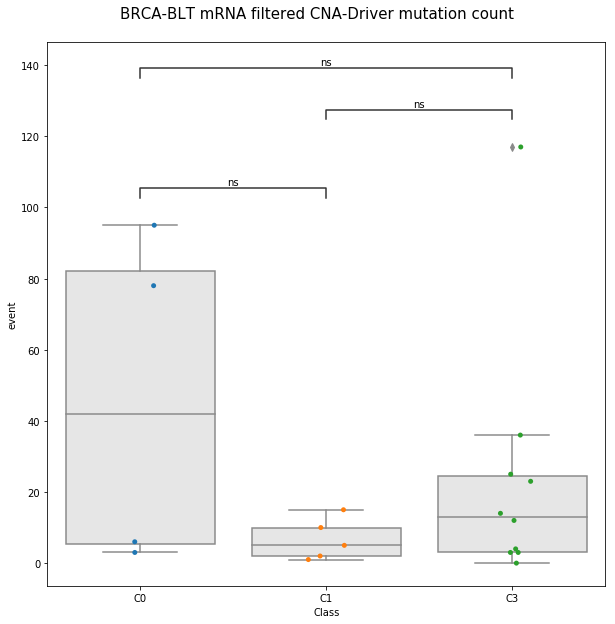

In [55]:
result = pd.merge(event_count_pd, table_original_network, left_on='node_name', right_on='node')
fig, ax = plt.subplots(1, 1, figsize=(10,10))
fig.suptitle('BRCA-BLT mRNA filtered CNA-Driver mutation count', fontsize=15, y=0.93)
ax = sns.stripplot(data=result.sort_values('Class'), x='Class', y='event')
ax = sns.boxplot(data=result.sort_values('Class'), x='Class', y='event', color='.9', ax=ax)

add_stat_annotation(ax=ax, data=result.sort_values('Class'), x='Class', y='event',
                    box_pairs=[("C0", "C1"), ("C1", "C3"), ("C0", "C3")],
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
# plt.savefig('../data/BLCA_200919/alter_freq_BLCA.pdf', dpi=300)

In [56]:
oncoprint_node_pd = pd.merge(alteration_cna_driver_melt_pd, gene_node_pd, left_on='track_name', right_on='gene_symbol')
oncoprint_node_class_pd = pd.merge(oncoprint_node_pd.dropna(), table_original_network[['node', 'Class']], left_on='node_name', right_on='node')

In [57]:
# oncoprint_node_class_pd['mutation_sign'] = 1*(oncoprint_node_class_pd['oncoKB'] == 'Oncogene') - 1*(oncoprint_node_class_pd['oncoKB'] == 'Tumor Suppressor')
# oncoprint_node_class_pd.head()

In [58]:
set(oncoprint_node_class_pd['event'])

{'Amplification',
 'Deep Deletion',
 'Inframe Mutation (putative driver)',
 'Missense Mutation (putative driver)',
 'Truncating mutation (putative driver)'}

In [59]:
oncoprint_node_class_pd['alteration'] = 1
# oncoprint_node_class_pd['alteration'] = 100 * (oncoprint_node_class_pd['event'] == 'Amplification') - 100 * (oncoprint_node_class_pd['event'] == 'Deep Deletion') -10 * (oncoprint_node_class_pd['event'].str.contains('Truncating mutation')) + 1 * (oncoprint_node_class_pd['event'].str.contains('Mutation')) * oncoprint_node_class_pd['mutation_sign']
print(oncoprint_node_class_pd.head())

        Case ID track_name          event track_type gene_symbol node_name  \
0  TCGA-A8-A06R       AKT1  Amplification        CNA        AKT1       AKT   
1  TCGA-AC-A3W5       AKT1  Amplification        CNA        AKT1       AKT   
2  TCGA-AN-A0AS       AKT1  Amplification        CNA        AKT1       AKT   
3  TCGA-AO-A0JD       AKT1  Amplification        CNA        AKT1       AKT   
4  TCGA-BH-A0HY       AKT1  Amplification        CNA        AKT1       AKT   

  node Class  alteration  
0  AKT    C3           1  
1  AKT    C3           1  
2  AKT    C3           1  
3  AKT    C3           1  
4  AKT    C3           1  


Class          C0   C1   C3  score
Case ID                           
TCGA-3C-AAAU  1.0  0.0  1.0    1.0
TCGA-3C-AALJ  0.0  1.0  1.0    0.0
TCGA-5T-A9QA  1.0  0.0  0.0    0.0
TCGA-A1-A0SD  1.0  0.0  1.0    1.0
TCGA-A1-A0SM  1.0  0.0  0.0    0.0


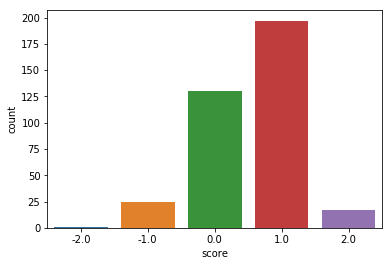

In [60]:
oncoprint_reverse_controllability = pd.pivot_table(oncoprint_node_class_pd[['Case ID', 'Class', 'alteration']], index='Case ID', columns='Class', values='alteration', aggfunc=np.sum)
oncoprint_reverse_controllability = oncoprint_reverse_controllability.fillna(0)

oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
# oncoprint_reverse_controllability['score'] = oncoprint_reverse_controllability['C2'] + oncoprint_reverse_controllability['C3'] - oncoprint_reverse_controllability['C1']
print(oncoprint_reverse_controllability.head())

sns.countplot(data=oncoprint_reverse_controllability, x='score')

In [61]:
os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
pfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, pfs_pd, left_index=True, right_on='Case ID')

Text(0, 0.5, 'Survival')

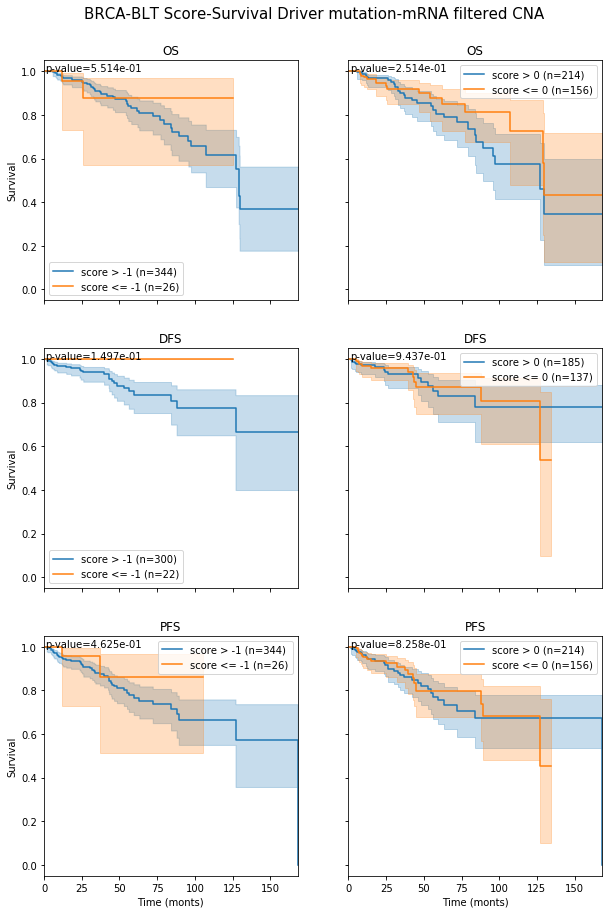

In [62]:
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(3, 2, figsize=(10, 15), sharey=True, sharex=True)
f.suptitle('BRCA-BLT Score-Survival Driver mutation-mRNA filtered CNA', fontsize=15, y=0.93)

ax = axes[0,1]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,1]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,1]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > 0 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 0 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

# ax = axes[0,2]
# data = os_oncoprint_pd
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['score'] > 1.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(1, 1, 'p-value=%.3e'% results.p_value)
# ax.set_title('OS')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Survival')

# ax = axes[1,2]
# data = dfs_oncoprint_pd
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['score'] > 1.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(1, 1, 'p-value=%.3e'% results.p_value)
# ax.set_title('DFS')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Survival')

# ax = axes[2,2]
# data = pfs_oncoprint_pd
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['score'] > 1.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'score > 1 (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= 1 (n=%d)'%np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(1, 1, 'p-value=%.3e'% results.p_value)
# ax.set_title('PFS')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Survival')

ax = axes[0,0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('OS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[1,0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('DFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

ax = axes[2,0]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['score'] > -1.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'score > -1 (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'score <= -1 (n=%d)'%np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('PFS')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Survival')

Text(0, 0.5, 'Overall survival')

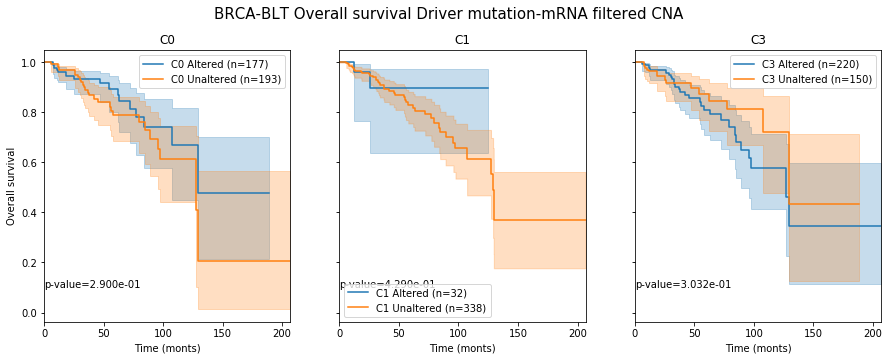

In [63]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Overall survival Driver mutation-mRNA filtered CNA', fontsize=15, y=1)

ax = axes[0]
data = os_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

# ax = axes[1,0]
# # data = c2_data
# T = data['Time (months)']
# E = data['Status'] == 'deceased'
# altered = (data['C2'] > 0.0)
# kmf.fit(T[altered], event_observed=E[altered], label = 'C2 Altered (n=%d)' %np.sum(altered))
# kmf.plot(ax=ax)
# kmf.fit(T[~altered], event_observed=E[~altered], label = 'C2 Unaltered (n=%d)' %np.sum(~altered))
# kmf.plot(ax=ax)
# results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
# ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
# ax.set_title('C2')
# ax.set_xlabel('Time (monts)')
# ax.set_ylabel('Overall survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Overall survival')

Text(0, 0.5, 'Disease free survival')

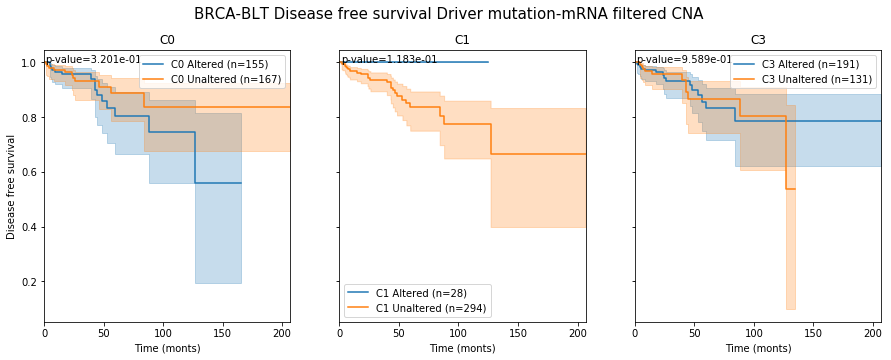

In [64]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Disease free survival Driver mutation-mRNA filtered CNA', fontsize=15, y=1)

ax = axes[0]
data = dfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(1, 1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Disease free survival')

Text(0, 0.5, 'Progression free survival')

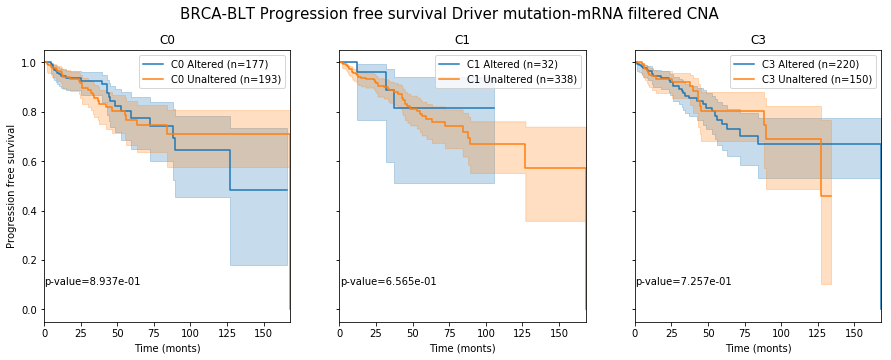

In [65]:
# os_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, os_pd, left_index=True, right_on='Case ID')
# dfs_oncoprint_pd = pd.merge(oncoprint_reverse_controllability, dfs_pd, left_index=True, right_on='Case ID')
# print(os_oncoprint_pd.head())
f, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
f.suptitle('BRCA-BLT Progression free survival Driver mutation-mRNA filtered CNA', fontsize=15, y=1)

ax = axes[0]
data = pfs_oncoprint_pd
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C0'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C0 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C0 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C0')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

ax = axes[1]
# data = c1_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C1'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C1 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C1 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C1')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')

ax = axes[2]
# data = c3_data
T = data['Time (months)']
E = data['Status'] == 'deceased'
altered = (data['C3'] > 0.0)
kmf.fit(T[altered], event_observed=E[altered], label = 'C3 Altered (n=%d)' %np.sum(altered))
kmf.plot(ax=ax)
kmf.fit(T[~altered], event_observed=E[~altered], label = 'C3 Unaltered (n=%d)' %np.sum(~altered))
kmf.plot(ax=ax)
results = logrank_test(T[altered], T[~altered], E[altered], E[~altered], alpha=.99)
ax.text(0.1, 0.1, 'p-value=%.3e'% results.p_value)
ax.set_title('C3')
ax.set_xlabel('Time (monts)')
ax.set_ylabel('Progression free survival')